# CASA 6.2 Notebook Demo

Original Author: rraba@nrao.edu



## Description

This notebook shows how to install the modular CASA 6 tools and tasks with some basic orientation:

- locate the casadata folder 
- list the available tasks
- find and print the log file
- run a simple tclean command
- view the output images with Astropy
- view the output images with CARTA


## Installation


In [1]:
import os

print("installing pre-requisite packages...")
os.system("apt-get install libgfortran3")

print("installing casatools...")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks==6.2.0.106")
os.system("pip install --index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casadata")

print("downloading MeasurementSet from CASAguide First Look at Imaging...\n")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print("make a config file for Google Colab...\n")
os.system("mkdir ~/.casa")
!echo "home     = '/content/'" > ~/.casa/config.py
!echo "datapath = ['`find / -type d -name casadata`']" >> ~/.casa/config.py
!more ~/.casa/config.py

installing pre-requisite packages...
installing casatools...
downloading MeasurementSet from CASAguide First Look at Imaging...

make a config file for Google Colab...

home     = '/content/'
datapath = ['/usr/local/lib/python3.7/dist-packages/casadata']


## Getting Started

In [2]:
import casatasks
dir(casatasks)

['__all__',
 '__builtins__',
 '__cached__',
 '__cwd',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__os',
 '__package__',
 '__path__',
 '__spec__',
 '_clith_spec',
 '_logsink',
 '_pipe_spec',
 '_time',
 'absolute_import',
 'accor',
 'applycal',
 'asdmsummary',
 'bandpass',
 'blcal',
 'calstat',
 'casalog',
 'clearcal',
 'clearstat',
 'concat',
 'config',
 'conjugatevis',
 'cvel',
 'cvel2',
 'delmod',
 'exportasdm',
 'exportfits',
 'exportuvfits',
 'feather',
 'fixplanets',
 'fixvis',
 'flagcmd',
 'flagdata',
 'flagmanager',
 'fluxscale',
 'fringefit',
 'ft',
 'gaincal',
 'gencal',
 'hanningsmooth',
 'imcollapse',
 'imcontsub',
 'imdev',
 'imfit',
 'imhead',
 'imhistory',
 'immath',
 'immoments',
 'impbcor',
 'importasap',
 'importasdm',
 'importatca',
 'importfits',
 'importfitsidi',
 'importgmrt',
 'importlib',
 'importmiriad',
 'importnro',
 'importuvfits',
 'importvla',
 'impv',
 'imrebin',
 'imreframe',
 'imregrid',
 'imsmooth',
 'imstat',
 'imsubimage',
 'imtrans',
 'imv

In [3]:
from casatasks import listobs

rc = listobs(vis='sis14_twhya_calibrated_flagged.ms')

print(os.popen("cat casa-*.log").read())

2021-05-12 17:24:05	INFO	::casa	
2021-05-12 17:24:06	INFO	::casa	CASA Version MODULAR 6.2.0.106
2021-05-12 17:24:06	INFO	::casa	Can't import casatelemetry module.
2021-05-12 17:24:06	INFO	listobs::::casa	##########################################
2021-05-12 17:24:06	INFO	listobs::::casa	##### Begin Task: listobs            #####
2021-05-12 17:24:06	INFO	listobs::::casa	listobs( vis='sis14_twhya_calibrated_flagged.ms', selectdata=True, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', feed='', array='', observation='', verbose=True, listfile='', listunfl=False, cachesize=50.0, overwrite=False )
2021-05-12 17:24:06	INFO	listobs::ms::summary	================================================================================
2021-05-12 17:24:06	INFO	listobs::ms::summary+	           MeasurementSet Name:  /content/sis14_twhya_calibrated_flagged.ms      MS Version 2
2021-05-12 17:24:06	INFO	listobs::ms::summary+	==========================================

## tclean Example
Note: Only non-interactive mode is supported (interactive=False) as the CASA Viewer is not compatible.

In [4]:
from casatasks import tclean

print("running tclean, may take a bit...")

tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='first_image',
       field='5', spw='', specmode='mfs', deconvolver='hogbom', nterms=1,
       gridder='standard', imsize=[250,250], cell=['0.1arcsec'],
       weighting='natural', threshold='0mJy', niter=5000, 
       interactive=False, savemodel='modelcolumn')

print("complete")

running tclean, may take a bit...
complete


## View Images with Astropy


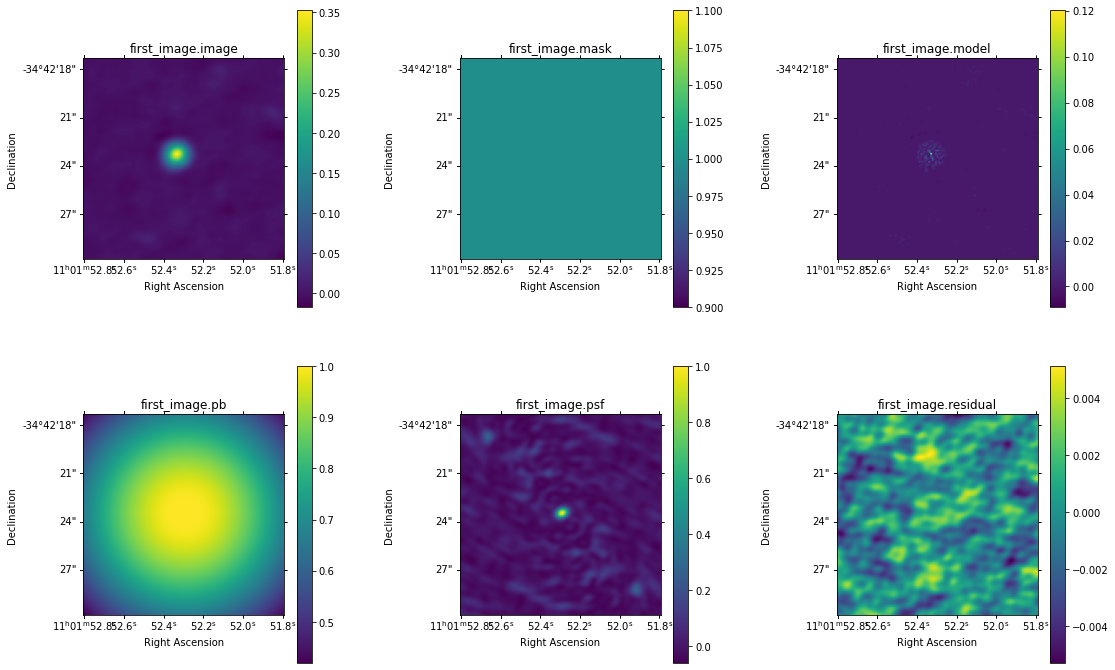

In [5]:
from casatools import image as IA
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

filenames = ['first_image.image', 'first_image.mask', 'first_image.model', 
             'first_image.pb', 'first_image.psf', 'first_image.residual']

ia = IA()

def buildImage(imname='',chan=0):
    ia.open(imname)
    pix = ia.getchunk()[:,:,0,chan]
    csys = ia.coordsys()
    ia.close()
    
    rad_to_deg =  180/np.pi
    w = WCS(naxis=2)
    w.wcs.crpix = csys.referencepixel()['numeric'][0:2]
    w.wcs.cdelt = csys.increment()['numeric'][0:2]*rad_to_deg
    w.wcs.crval = csys.referencevalue()['numeric'][0:2]*rad_to_deg
    w.wcs.ctype = ['RA---SIN', 'DEC--SIN']
    
    return pix, w

plt.subplots(2,3, figsize=(18,12))
for ii, name in enumerate(filenames):
    pix, w = buildImage(name)
    ax = plt.subplot(2, 3, ii+1, projection=w)
    p1 = int(pix.shape[0]*0.25)
    p2 = int(pix.shape[0]*0.75)

    im = ax.imshow(pix[p1:p2,p1:p2].transpose(), origin='lower',  cmap=plt.cm.viridis)
    plt.colorbar(im, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

plt.subplots_adjust(wspace=0.5, hspace=0.2)

## View Images with CARTA
Consider this very experimental, even a bit magical

In [6]:
import os
import subprocess as sp
import socket
import signal
import time
import requests

FRONT_PORT = '39138'  # make something up
BACK_PORT = '41578'
HOST_IP = socket.gethostbyname(socket.gethostname()) 

print("downloading ngrok...")
os.system("wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip")
os.system("unzip -o ngrok-stable-linux-amd64.zip");

print("downloading CARTA...")
os.system("wget https://github.com/CARTAvis/carta/releases/download/v1.4/CARTA-v1.4-RedHat7.tgz")
os.system("tar -xf CARTA-v1.4-RedHat7.tgz")
os.system("./CARTA.AppImage --appimage-extract")
os.system("rm squashfs-root/resources/app/carta-backend/lib/libstdc++.so.6")

#cp = sp.Popen('CARTA-v1.1-remote/carta --port='+BACK_PORT + ' --fport='+FRONT_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)
cp = sp.Popen('./squashfs-root/AppRun --remote --port='+BACK_PORT + ' --fport='+FRONT_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)
gp1 = sp.Popen('./ngrok http ' + HOST_IP+':'+FRONT_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)
gp2 = sp.Popen('./ngrok http ' + HOST_IP+':'+BACK_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)

time.sleep(2) # give the processes time to start
fcon = requests.get('http://localhost:4040/api/tunnels').json()['tunnels']
bcon = requests.get('http://localhost:4041/api/tunnels').json()['tunnels']
furl = [fcon[ii]['public_url'] for ii in range(len(fcon)) if fcon[ii]['proto'] == 'https'][0]
burl = [bcon[ii]['public_url'] for ii in range(len(bcon)) if bcon[ii]['proto'] == 'https'][0]
print('click this -> ' + furl +'/?socketUrl=' + burl.replace('https','wss'))

downloading ngrok...
downloading CARTA...
click this -> https://49d90692514c.ngrok.io/?socketUrl=wss://688d91fe9766.ngrok.io


In [7]:
# turn it off
os.killpg(os.getpgid(gp1.pid), signal.SIGTERM)
os.killpg(os.getpgid(gp2.pid), signal.SIGTERM)
os.killpg(os.getpgid(cp.pid), signal.SIGTERM)
print("stopped CARTA and the secure tunnels")

stopped CARTA and the secure tunnels
